In [48]:
import os
from dotenv import load_dotenv
import snowflake.connector
import pandas as pd
import plotly.express as px
# Use Plotly's "make_subplots" function from "plotly.subplots" to layout elements horizontally
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Load credentials
load_dotenv()

True

In [49]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT') + '.' + os.getenv('SNOWFLAKE_REGION'),
    warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
    database='WALMART_DB',
    schema='SILVER',
    role=os.getenv('SNOWFLAKE_ROLE')
)

In [50]:
# SQL query
sql = """
SELECT 
    store_id, 
    is_holiday,
    AVG(store_weekly_sales) AS avg_weekly_sales,
    SUM(store_weekly_sales) AS total_weekly_sales    
FROM walmart_fact_table
GROUP BY store_id, is_holiday
ORDER BY store_id, is_holiday
"""

# Run query using Snowflake connector
cur = conn.cursor()
cur.execute(sql)

# Load results into DataFrame
columns = [col[0] for col in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data, columns=columns)

# Force column names to lowercase so Snowflake will match the model table
df.columns = [col.lower() for col in df.columns]

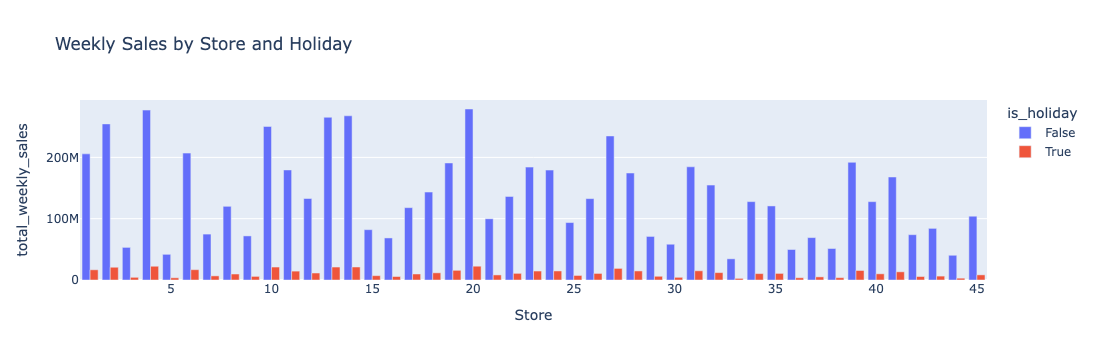

In [51]:
# Plot using Plotly
fig = px.bar(
    df,
    x='store_id',
    y='total_weekly_sales',
    color='is_holiday',
    barmode='group',
    title='Weekly Sales by Store and Holiday',
    labels={'store_id': 'Store', 'weekly_sales': 'Total Weekly Sales'}
)

fig.show()

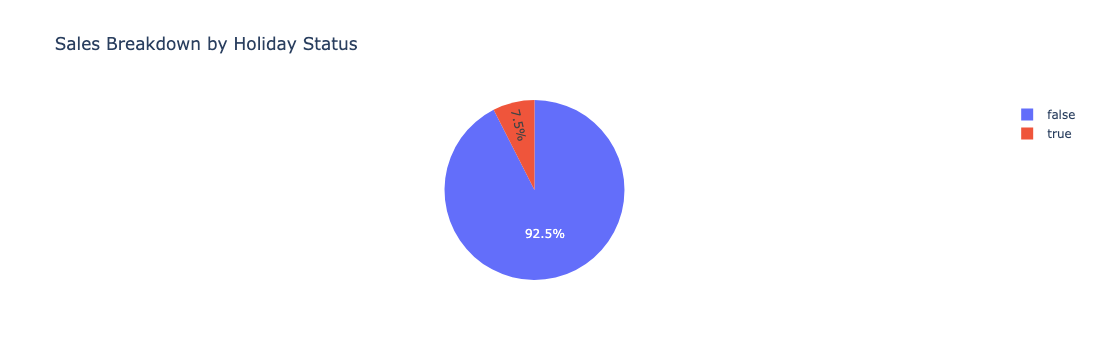

In [52]:
pie_df = df.groupby('is_holiday', as_index=False)['total_weekly_sales'].sum()

fig_pie = px.pie(
    pie_df,
    names='is_holiday',
    values='total_weekly_sales',
    title='Sales Breakdown by Holiday Status'
)
fig_pie.show()


In [53]:
total_sales = df['total_weekly_sales'].sum()
print(f"Total Weekly Sales: {total_sales / 1e9:.2f} bn")

Total Weekly Sales: 6.74 bn


In [54]:
top_group = pie_df.sort_values('total_weekly_sales', ascending=False).iloc[0]
print(f"Peak Holiday Group: {top_group['is_holiday']}")

Peak Holiday Group: False


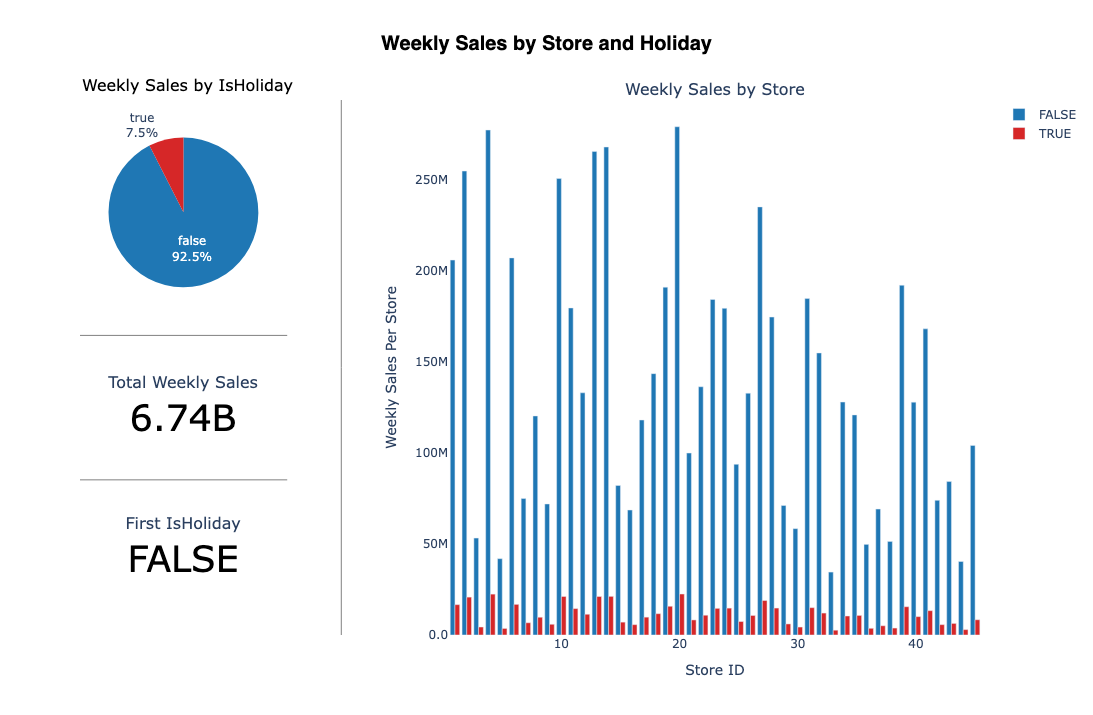

In [149]:
# Let's combine the graph and the summary table into a single dashboard-style presentation

# First, set up the overall container for the charts.  Here, we have a 3-row, 2-column
# layout where row1,col2 spans 3 rows
fig = make_subplots(
    rows=3,
    cols=2,
    specs=[
        [{'type':"domain", 't':0.07, 'b':0}, {"type": "xy", "rowspan": 3}],
        [{"type": "indicator", 't':0}, None],
        [{"type": "indicator", 't':-0.06}, None]
    ],
    column_widths=[0.28, 0.72],
    row_heights=[0.5, 0.25, 0.25],
    horizontal_spacing=0.18,
    vertical_spacing=0.15,
    subplot_titles=(
        "",
        "Weekly Sales by Store",
        "",
        ""
    )
)

# Next, let's add the pie chart to the first cell in row 1
pie_trace =  go.Pie(
    labels = df['is_holiday'],
    values = df['total_weekly_sales'],
    textinfo = 'label+percent',
    marker = dict(colors=['#1f77b4', '#d62728']), # false = blue, true = red
    hovertemplate='Is Holiday: %{label}<br>Total Weekly Sales: %{value:$,.2f}<extra></extra>',
    showlegend = False
)

fig.add_trace(pie_trace, row=1, col=1)

# Since adding the title for this cell in the subplots section could (and does) overlap
# a thin pie slice label, add a separate annotation for the title where we can control 
# the text, font, color, position, etc.
fig.add_annotation(
    text="Weekly Sales by IsHoliday",
    x=0.0,  # roughly center of left column
    y=1.05,  # above the pie chart
    xref="paper",
    yref="paper",
    showarrow=False,
    font=dict(size=16, color="black")
)

# ========================================

# Next, add the weekly sales indicator to row2, col1
def formatTotalSales(value):
    if value >= 1_000_000_000:
        return f"{value / 1_000_000_000:.2f}B"
    elif value >= 1_000_000:
        return f"{value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value / 1_000:.2f}K"
    else:
        return f"{value:2f}"
        
totalSales = df['total_weekly_sales'].sum()
totalSalesFormattedStr = formatTotalSales(totalSales)

weekly_sales_indicator = go.Table(
    header = dict(
        values = ["Total Weekly Sales"],
        fill_color = 'white',
        align = 'center',
        font = dict(size=16)
    ),
    cells = dict (
        values = [[totalSalesFormattedStr]],
        align = 'center',
        fill_color = 'white',
        font = dict(size=36, color='black')
    )
)

fig.add_trace(weekly_sales_indicator, row=2, col=1)

# ========================================

# Next, add the first holiday indicator, row3, col1

first_holiday_indicator = go.Table(
    header = dict(
        values = ["First IsHoliday"],
        fill_color = 'white',
        align = 'center',
        font = dict(size=16)
    ),
    cells = dict(
        values = [[str(top_group['is_holiday']).upper()]],
        align = 'center',
        fill_color = 'white',
        font = dict(size=36, color='black')
    )
)

fig.add_trace(first_holiday_indicator, row=3, col=1)

# ========================================

# Finally, add the grouped bar chart to col 2
colors = {'FALSE': '#1f77b4', 'TRUE':'#d62728'}
for isHoliday in df['is_holiday'].unique():  # Only need the list [True, False], not [True, False, False, True, True, True...]
    df_subset = df[df['is_holiday'] == isHoliday]
    fig.add_trace(
        go.Bar(
            x = df_subset['store_id'],
            y = df_subset['total_weekly_sales'],
            marker_color = colors[str(isHoliday).upper()],
            name = str(isHoliday).upper(),
            hovertemplate = 'Store: %{x}<br>Total Weekly Sales: %{y:$,.2f}<extra></extra>'
        ),
        row = 1,
        col = 2
)

# Final layout adjustments
fig.update_layout(
    height = 700,
    width = 1100,
    title = 'Weekly Sales by Store and Holiday',
    title_x = 0.5,
    xaxis_title = 'Store ID',
    yaxis_title = 'Weekly Sales Per Store',
    yaxis_tickformat = ".2s",
    barmode = 'group',  # for grouped chart
    plot_bgcolor = 'white'
)

# Let's make the report title pop a little more
title_font = dict(size=20, family="Helvetica", color='black', weight='bold')
fig.update_layout(title=dict(text='Weekly Sales by Store and Holiday', x=0.5, font=title_font))

# Add some line separators
# Horizontal, between pie chart and total weekly sales
fig.add_shape(
    type="line",
    x0=0.0, x1=.23,
    y0=0.56, y1=0.56,
    xref="paper", yref="paper",
    line=dict(color="grey", width=1),
    layer="below"
)

# Horizontal, between total weekly sales and first holiday
fig.add_shape(
    type="line",
    x0=0.0, x1=.23,
    y0=0.29, y1=0.29,
    xref="paper", yref="paper",
    line=dict(color="grey", width=1),
    layer="below"
)

# Vertical, between col1 and col2
fig.add_shape(
    type="line",
    x0=0.29, x1=.29,
    y0=0.0, y1=1.0,
    xref="paper", yref="paper",
    line=dict(color="grey", width=1),
    layer="below"
)

fig.show()


In [35]:
# Close the connection
conn.close()